# 读取数据

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv("example.txt",header=None)
df.columns=['用户id','物品id','喜好程度']
df.head()

,用户id,物品id,喜好程度
0,0,1,5
1,0,2,4
2,0,3,3
3,0,4,5
4,1,1,4


In [3]:
#得到用户物品评分矩阵
dfpivot= df.pivot(index="用户id",columns="物品id",values="喜好程度")
dfpivot 

物品id,0,1,2,3,4,5
用户id,,,,,,
0,NaN,5.0,4.0,3.0,5.0,NaN
1,NaN,4.0,3.0,NaN,NaN,5.0
2,NaN,5.0,NaN,4.0,NaN,4.0
3,NaN,4.0,NaN,5.0,3.0,4.0
4,5.0,3.0,3.0,3.0,NaN,NaN
5,4.0,NaN,4.0,5.0,NaN,4.0


In [4]:
freq= dfpivot.fillna(0)
freq

物品id,0,1,2,3,4,5
用户id,,,,,,
0,0.0,5.0,4.0,3.0,5.0,0.0
1,0.0,4.0,3.0,0.0,0.0,5.0
2,0.0,5.0,0.0,4.0,0.0,4.0
3,0.0,4.0,0.0,5.0,3.0,4.0
4,5.0,3.0,3.0,3.0,0.0,0.0
5,4.0,0.0,4.0,5.0,0.0,4.0


In [5]:
freqmatrix = freq.values
freqmatrix

array([[0., 5., 4., 3., 5., 0.],
       [0., 4., 3., 0., 0., 5.],
       [0., 5., 0., 4., 0., 4.],
       [0., 4., 0., 5., 3., 4.],
       [5., 3., 3., 3., 0., 0.],
       [4., 0., 4., 5., 0., 4.]])

# 计算物品的相似性

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
item_similar=cosine_similarity(freqmatrix.T)  #物品的相似度
item_similar

array([[1.        , 0.24557188, 0.68467546, 0.5963984 , 0.        ,
        0.2924601 ],
       [0.24557188, 1.        , 0.60782444, 0.73201442, 0.66518366,
        0.68707778],
       [0.68467546, 0.60782444, 1.        , 0.63264373, 0.48507125,
        0.51311565],
       [0.5963984 , 0.73201442, 0.63264373, 1.        , 0.56136089,
        0.71513322],
       [0.        , 0.66518366, 0.48507125, 0.56136089, 1.        ,
        0.24086869],
       [0.2924601 , 0.68707778, 0.51311565, 0.71513322, 0.24086869,
        1.        ]])

In [7]:
pd.DataFrame(item_similar)#物品的相似度

,0,1,2,3,4,5
0,1.000000,0.245572,0.684675,0.596398,0.000000,0.292460
1,0.245572,1.000000,0.607824,0.732014,0.665184,0.687078
2,0.684675,0.607824,1.000000,0.632644,0.485071,0.513116
3,0.596398,0.732014,0.632644,1.000000,0.561361,0.715133
4,0.000000,0.665184,0.485071,0.561361,1.000000,0.240869
5,0.292460,0.687078,0.513116,0.715133,0.240869,1.000000


# 得到推荐分值，减去平均值

In [12]:
#构建一个基于物品的推荐
def Recommendation_s(uid,iid,similar,k=10): #2,2，第2个物品对第2个用户的推荐分值
    score = 0
    weight = 0
    iid_action = freqmatrix[:,iid]      #物品iid 得到的所有用户评分  
    iid_i_mean = np.sum(iid_action)/iid_action[iid_action!=0].size  #物品得到用户的平均评分
    uid_action = freqmatrix[uid,:]      #用户uid 对所有商品的行为评分  
    iid_sim = similar[iid,:]      #商品iid 和所有商品的相似度    
    sim_indexs = np.argsort(iid_sim)[-(k+1):-1]  #最相似的k个物品的index（除了自己）
    
    for j in sim_indexs : #0,3
        if uid_action[j]!=0:  #表示用户用过该物品，用户对该物品有过评分
            iid_j_action = freqmatrix[:,j] #表示相似的那个物品得到所有用户的评分
            iid_j_mean = np.sum(iid_j_action)/iid_j_action[iid_j_action!=0].size #表示相似的那个物品得到所有用户的平均得分
            
            score += iid_sim[j]*(uid_action[j]-iid_j_mean)
            weight += abs(iid_sim[j])

    if weight==0:  
        return 0
    else:
        return iid_i_mean + score/float(weight)

In [13]:
Recommendation_s(2,2,item_similar, 2)  #预测的第二个用户对第二个物品的喜欢程度

3.5

In [14]:
#构建预测函数
def predict(similar):
    user_cnt = freqmatrix.shape[0]
    item_cnt = freqmatrix.shape[1]
    pred = np.zeros((user_cnt,item_cnt))
    for uid in range(user_cnt):
        for iid in range(item_cnt):
            if freqmatrix[uid,iid] == 0: #表示用户没有用过该物品，给其做推荐
                pred[uid,iid] = Recommendation_s(uid,iid,similar)
    return pred

In [15]:
user_prediction = predict(item_similar)
user_prediction

array([[4.46226815, 0.        , 0.        , 0.        , 0.        ,
        4.40395429],
       [4.35924104, 0.        , 0.        , 4.03540026, 3.85988245,
        0.        ],
       [4.60872635, 0.        , 3.7041423 , 0.        , 4.32160658,
        0.        ],
       [4.91797982, 0.        , 3.45431573, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 3.06397399,
        3.5026659 ],
       [0.        , 4.52623762, 0.        , 0.        , 4.57770439,
        0.        ]])

In [16]:
pd.DataFrame(user_prediction)

,0,1,2,3,4,5
0,4.462268,0.000000,0.000000,0.0000,0.000000,4.403954
1,4.359241,0.000000,0.000000,4.0354,3.859882,0.000000
2,4.608726,0.000000,3.704142,0.0000,4.321607,0.000000
3,4.917980,0.000000,3.454316,0.0000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.0000,3.063974,3.502666
5,0.000000,4.526238,0.000000,0.0000,4.577704,0.000000


# top n 推荐：基于物品的推荐，减去平均值，完整代码

In [17]:
#导入相关库
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


#构建一个基于物品的推荐
def Recommendation_s(uid,iid,similar,k=10): #2,2，第2个物品对第2个用户的推荐分值
    score = 0
    weight = 0
    uid_action = freqmatrix[uid,:]      #用户uid 对所有商品的行为评分  
    iid_action = freqmatrix[:,iid]      #物品iid 得到的所有用户评分  
    iid_sim = similar[iid,:]      #商品iid 和所有商品的相似度    
    sim_indexs = np.argsort(iid_sim)[-(k+1):-1]  #最相似的k个物品的index（除了自己）
    
    iid_i_mean = np.sum(iid_action)/iid_action[iid_action!=0].size
    
    for j in sim_indexs : #0,6
        if uid_action[j]!=0:  #表示用户用过该物品，用户对该物品有过评分
            iid_j_action = freqmatrix[:,j]
            iid_j_mean = np.sum(iid_j_action)/iid_j_action[iid_j_action!=0].size
            score += iid_sim[j]*(uid_action[j]-iid_j_mean)
            weight += abs(iid_sim[j])

    if weight==0:  
        return 0
    else:
        return iid_i_mean + score/float(weight)

    
#构建预测函数
def predict_mean(similar):
    user_cnt = freqmatrix.shape[0]
    item_cnt = freqmatrix.shape[1]
    pred = np.zeros((user_cnt,item_cnt))
    for uid in range(user_cnt):
        for iid in range(item_cnt):
            if freqmatrix[uid,iid] == 0: #表示用户没有用过该物品
                #print (uid,iid)
                pred[uid,iid] = Recommendation_s(uid,iid,similar)
    return pred

def get_topk(group,n):
    return group.sort_values("推荐指数",ascending=False)[:n]

#读取数据
df = pd.read_csv("example.txt",header=None)
df.columns=['用户id','物品id','喜好程度']

#建立关系矩阵
dfpivot= df.pivot(index="用户id",columns="物品id",values="喜好程度")

#填充0
freq= dfpivot.fillna(0)

#取出值，得到评分数组
freq_matrix = freq.values

#计算相似性矩阵
item_similar=cosine_similarity(freq_matrix.T)#计算物品的相似性

#得到预测分数矩阵
user_prediction_matrix = predict_mean(item_similar)

#得到预测分数的dataframe
recommendation_df = pd.DataFrame(user_prediction_matrix,columns=freq.columns,index=freq.index)

recommendation_df_2 = recommendation_df.stack().reset_index()
recommendation_df_2.rename(columns={0:"推荐指数"},inplace=True)

recommendation_df_grouped = recommendation_df_2.groupby("用户id")

#获得top n推荐
topk = recommendation_df_grouped.apply(get_topk,n=3) #推荐几个

top_n=topk[['用户id','物品id','推荐指数']].reset_index(drop=True)
top_n

,用户id,物品id,推荐指数
0,0,0,4.462268
1,0,5,4.403954
2,0,1,0.000000
3,1,0,4.359241
4,1,3,4.035400
5,1,4,3.859882
6,2,0,4.608726
7,2,4,4.321607
8,2,2,3.704142
9,3,0,4.917980


# 做预测（评估模型性能）

In [18]:
#导入相关库
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#构建一个基于物品的推荐
def Recommendation_s(uid,iid,similar,k=10): #2,2，第2个物品对第2个用户的推荐分值
    score = 0
    weight = 0
    uid_action = freqmatrix[uid,:]      #用户uid 对所有商品的行为评分  
    iid_action = freqmatrix[:,iid]      #物品iid 得到的所有用户评分  
    
    iid_sim = similar[iid,:]      #商品iid 和所有商品的相似度    
    sim_indexs = np.argsort(iid_sim)[-(k+1):-1]  #最相似的k个物品的index（除了自己）
    
    iid_i_mean = np.sum(iid_action)/iid_action[iid_action!=0].size
    
    for j in sim_indexs : #0,6
        if uid_action[j]!=0:  #表示用户用过该物品，用户对该物品有过评分
            iid_j_action = freqmatrix[:,j]
            iid_j_mean = np.sum(iid_j_action)/iid_j_action[iid_j_action!=0].size
            score += iid_sim[j]*(uid_action[j]-iid_j_mean)
            weight += abs(iid_sim[j])

    if weight==0:  
        return 0
    else:
        return iid_i_mean + score/float(weight)

    
#构建预测函数
def predict_mean(similar):
    user_cnt = freqmatrix.shape[0]
    item_cnt = freqmatrix.shape[1]
    pred = np.zeros((user_cnt,item_cnt))
    for uid in range(user_cnt):
        for iid in range(item_cnt):
            if freqmatrix[uid,iid] != 0: #表示用户用过该物品
                pred[uid,iid] = Recommendation_s(uid,iid,similar)
    return pred

#读取数据
df = pd.read_csv("example.txt",header=None)
df.columns=['用户id','物品id','喜好程度']

#建立关系矩阵
dfpivot= df.pivot(index="用户id",columns="物品id",values="喜好程度")

#填充0
freq= dfpivot.fillna(0)

#取出值，得到评分数组
freq_matrix = freq.values

#计算相似性矩阵
item_similar=cosine_similarity(freq_matrix.T)#计算物品的相似性

#得到预测分数矩阵
user_prediction_matrix = predict_mean(item_similar)
user_prediction_matrix

array([[0.        , 4.31824379, 3.69627895, 4.75975069, 4.12463174,
        0.        ],
       [0.        , 4.36325257, 3.73486701, 0.        , 0.        ,
        3.92174176],
       [0.        , 4.07895822, 0.        , 4.2811242 , 0.        ,
        4.6419968 ],
       [0.        , 4.14965221, 0.        , 3.55860427, 4.25085434,
        4.45501073],
       [3.69207033, 3.62403525, 2.97032766, 3.54282809, 0.        ,
        0.        ],
       [5.05011276, 0.        , 3.58851836, 3.91736309, 0.        ,
        4.79281326]])

In [19]:
(((user_prediction_matrix- freq_matrix)**2).mean())**0.5 #RMSE

0.6858531303941693

# 对k进行优化

In [20]:
#导入相关库
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#构建一个基于物品的推荐
def Recommendation_s(uid,iid,similar,k=10): #2,2，第2个物品对第2个用户的推荐分值
    score = 0
    weight = 0
    uid_action = freqmatrix[uid,:]      #用户uid 对所有商品的行为评分  
    iid_action = freqmatrix[:,iid]      #物品iid 得到的所有用户评分  
    
    iid_sim = similar[iid,:]      #商品iid 和所有商品的相似度    
    sim_indexs = np.argsort(iid_sim)[-(k+1):-1]  #最相似的k个物品的index（除了自己）
    
    iid_i_mean = np.sum(iid_action)/iid_action[iid_action!=0].size
    
    for j in sim_indexs : #0,6
        if uid_action[j]!=0:  #表示用户用过该物品，用户对该物品有过评分
            iid_j_action = freqmatrix[:,j]
            iid_j_mean = np.sum(iid_j_action)/iid_j_action[iid_j_action!=0].size
            score += iid_sim[j]*(uid_action[j]-iid_j_mean)
            weight += abs(iid_sim[j])

    if weight==0:  
        return 0
    else:
        return iid_i_mean + score/float(weight)

    
#构建预测函数
def predict_mean(similar,k):
    user_cnt = freqmatrix.shape[0]
    item_cnt = freqmatrix.shape[1]
    pred = np.zeros((user_cnt,item_cnt))
    for uid in range(user_cnt):
        for iid in range(item_cnt):
            if freqmatrix[uid,iid] != 0: #表示用户用过该物品
                pred[uid,iid] = Recommendation_s(uid,iid,similar,k)
    return pred

#读取数据
df = pd.read_csv("example.txt",header=None)
df.columns=['用户id','物品id','喜好程度']

#建立关系矩阵
dfpivot= df.pivot(index="用户id",columns="物品id",values="喜好程度")

#填充0
freq= dfpivot.fillna(0)

#取出值，得到评分数组
freq_matrix = freq.values

#计算相似性矩阵
item_similar=cosine_similarity(freq_matrix.T)#计算物品的相似性

#得到预测分数矩阵
RMSE_list=[]
for k in range(1,5):
    user_prediction_matrix = predict_mean(item_similar,k)
    RMSE=(((user_prediction_matrix- freq_matrix)**2).mean())**0.5 #RMSE
    RMSE_list.append(RMSE)

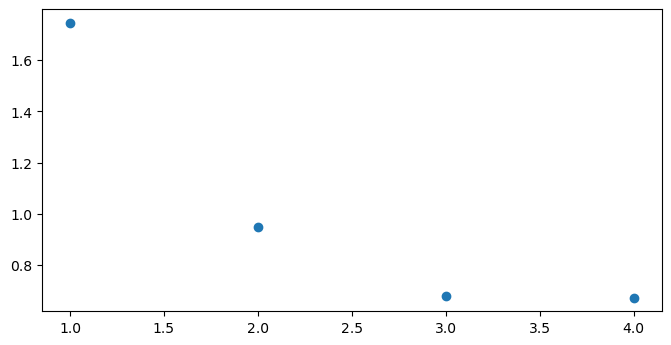

In [22]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(8,4),dpi=100) 
plt.scatter(range(1,5),RMSE_list)  #原数据散点图
plt.show()